In [1]:
import sys, os
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_DIR = os.path.join(BASE_DIR, "src")
sys.path.append(SRC_DIR)

In [2]:
import os
import random
import json 
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
from reporting.explore_stats_sumry import summarize_dataset_exclusive, classify_doc
from utils.io_utils import ensure_dir, read_jsonl, sample_jsonl, sample_docs
from reporting.explore_stats_sumry import quick_stats, show_longest_docs, summarize_dataset, summarize_dataset_exclusive


# Read clean file

In [3]:
clean_data_path='../data/clean'
clean_file=os.path.join(clean_data_path, "mainpipe_clean_data2.jsonl")

In [4]:
summary, summary_pct = summarize_dataset_exclusive(clean_file, sample_size=25000)
print(summary)
print(summary_pct)

Counter({'GOOD_ENGLISH': 24840, 'SHORT_ENGLISH': 113, 'HTML': 47})
{'GOOD_ENGLISH': 99.36, 'SHORT_ENGLISH': 0.45199999999999996, 'HTML': 0.188}


In [5]:
sum(i for i in list(summary_pct.values()))

100.0

### my cleaning pipiline is able to clean most code-heavy docs 

# Quick stats

In [6]:
quick_stats(clean_file, sample_size=25000)

FILE OVERVIEW
File size: 200.95 MB (0.20 GB)
Total lines in file: 107,320
Sampled (limit): 25,000
------------

KEYS
Most common keys: [('text', 25000)]
------------

TEXT LENGTH STATS
Avg length: 1829.51
Median length: 845.00
10th percentile: 284.00
90th percentile: 3951.00
Most entries are multi-paragraph documents (median text size>300).
Good for LLM pretraining (rich context, natural text).
Max length: 49749
raw HTML pages,  code dumps / stack traces, JSON logs or config files, full chat transcripts, base64 or encoded junk.
 These must be  filtered or trim these before LLM pretraining
Min length: 126
------------

NOISE INDICATORS
Empty texts: 0 (0.00%)
Short < 100 chars: 0 (0.00%)
Only a small fraction of trivial/low-value text.  Dataset likely contains substantial natural text, not noise
------------

Done.


for line in random.sample(list(open(clean_file)), 10000):
    row = json.loads(line)
    text = row["text"]
    if classify_doc(text) == "CODE_HEAVY":  #HTML CODE_HEAVY
        print(text[:500])
        print("-----")


When using strong code detect, there is 44% code heavy detection. So, when I print code heavy out of 20, 11 are found heavy. When I inspect those, only three 3 look like codes.
This is because after normalization each document (could be paragraph worth text) is one big line, and if in thatbig line there is any code-like simple, you get code_lines / len(lines)=1 which is >0.4. So the whole document is classified as code heavy now.

# Tokenization

Choosing the right tokenizer for data preprocessing in Natural Language Processing (NLP) depends on several factors, including the language of your data, the specific NLP task, and the characteristics of your dataset.
For English language with clear boundaries, for goal of semantic understanding (not very fine-grained analysis), Subword Tokenization should work well.

Subword Tokenization, such as Byte Pair Encoding, WordPiece, SentencePiece, balances vocabulary size and the ability to handle OOV words by breaking words into smaller units (subwords) based on statistical frequency.

In [7]:
#GPT-2 style BPE
enc=tiktoken.get_encoding("gpt2")

### Tokenizing few lines first

In [12]:
sample_documents = sample_docs(clean_file, n=2)

In [13]:
for i, text in enumerate(sample_documents):
    print(f"\n=== sample_documents {i} ===")
    print(text[:500], "...")
    tokens = enc.encode(text)
    print(f"Token count: {len(tokens)}")
    print("First 30 token IDs:", tokens[:30])
    print("Decode check:\n", enc.decode(tokens[:80]), "...")


=== sample_documents 0 ===
I understand - you didn't solicit it or search Facebook for it, the screenshot was sent to you. But it didn't come as a direct message from the publicist? So it's not really a direct message from the publicist, or Saffron's PR, but as screenshot of someone looking through his Facebook page. You see how that can read as a bit misleading? ...
Token count: 77
First 30 token IDs: [40, 1833, 532, 345, 1422, 470, 25063, 340, 393, 2989, 3203, 329, 340, 11, 262, 22032, 373, 1908, 284, 345, 13, 887, 340, 1422, 470, 1282, 355, 257, 1277, 3275]
Decode check:
 I understand - you didn't solicit it or search Facebook for it, the screenshot was sent to you. But it didn't come as a direct message from the publicist? So it's not really a direct message from the publicist, or Saffron's PR, but as screenshot of someone looking through his Facebook page. You see how that can read as a bit misleading? ...

=== sample_documents 1 ===
As mentioned before, I love that all of the bo

# Tokenizing whole samples

In [19]:
def token_length_stats(path, max_docs=None):
    lengths = []

    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_docs is not None and i >= max_docs:
                break
            row = json.loads(line)
            text = row.get("text", "")
            if not text.strip():
                continue
            tokens = enc.encode(text)
            lengths.append(len(tokens))

    arr = np.array(lengths)
    print(f"Docs counted: {len(arr)}")
    print(f"Avg tokens   : {arr.mean():.2f}")
    print(f"Median tokens: {np.median(arr):.2f}")
    print(f"95th pct     : {np.percentile(arr, 95):.2f}")
    print(f"99th pct     : {np.percentile(arr, 99):.2f}")
    print(f"Max tokens   : {arr.max()}")
    return arr


In [20]:
token_lengths = token_length_stats(clean_file, max_docs=None)  # or a subset first

Docs counted: 107320
Avg tokens   : 437.26
Median tokens: 203.00
95th pct     : 1376.00
99th pct     : 4184.24
Max tokens   : 14150


### 95% documents have token length < 2048

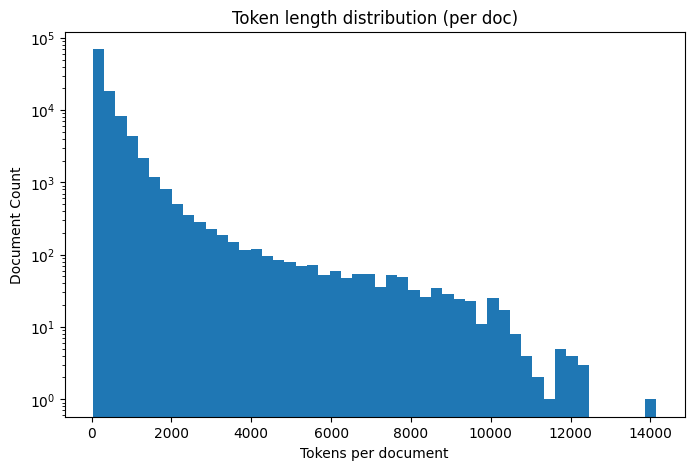

In [21]:
plt.figure(figsize=(8,5))
plt.hist(token_lengths, bins=50)
plt.xlabel("Tokens per document")
plt.ylabel("Document Count")
plt.title("Token length distribution (per doc)")
plt.yscale("log")  # often useful
plt.show()

### TODO
- decide max_seq_len for training (e.g. 1024, 2048, 4096).
- Whether many docs are longer than max_seq_len then chunking needed

### Because 95% documents have token length < 2048
max_seq_len=2048

In [22]:
def tokenize_to_jsonl(input_path, output_path, max_seq_len=2048, limit=None):
    """
    Reads cleaned JSONL with {"text": ...}, writes JSONL with {"input_ids": [...], "length": N}
    Truncates sequences longer than max_seq_len.
    """
    count_in = 0
    count_out = 0

    with open(input_path, "r", encoding="utf-8") as fin, \
         open(output_path, "w", encoding="utf-8") as fout:

        for line in fin:
            if limit is not None and count_in >= limit:
                break

            row = json.loads(line)
            text = row.get("text", "").strip()
            if not text:
                continue

            count_in += 1
            token_ids = enc.encode(text)

            # truncate for now
            if len(token_ids) > max_seq_len:
                token_ids = token_ids[:max_seq_len]

            out_row = {
                "input_ids": token_ids,
                "length": len(token_ids)
            }
            fout.write(json.dumps(out_row) + "\n")
            count_out += 1

    print(f"Read docs : {count_in}")
    print(f"Wrote docs: {count_out}")



In [23]:
tokenized_path = "../data/final/mainpipe_tokenized_gpt2.jsonl"
tokenize_to_jsonl(clean_file, tokenized_path, max_seq_len=2048)

Read docs : 107320
Wrote docs: 107320
